In [1]:
#This is the main preprocessing file

import cv2
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
import scipy.io as scio
import  os
import numpy as np
import matplotlib.pyplot as plt
#for dlib to use GPU and maybe get a better speed
import dlib.cuda as cuda;
import dlib
print(cuda.get_num_devices())
dlib.DLIB_USE_CUDA = True
print(dlib.DLIB_USE_CUDA)

Using TensorFlow backend.


1
True


In [2]:
# these functions adjust the head size and also fixes any rotation in the head
def compute_alignment(image, rex, rey, lex, ley, dist2=175, debug=False):
    h, w = np.shape(image)[0], np.shape(image)[1]
    # Calculating a center point of the image
    center = (w // 2, h // 2)

    ##fix rotation
    delx = rex-lex
    dely = rey-ley
    angle=np.arctan(dely/delx)

    #converto degrees
    angle = (angle * 180) / np.pi

    M = cv2.getRotationMatrix2D(center, (angle), 1.0)


    ##fix scaling
    # calculate distance between the eyes in the image for scaling later
    dist1 = np.sqrt((delx * delx) + (dely * dely))

    #calculate the ratio
    ratio = dist1 / dist2
    dim = (int(w * ratio), int(h * ratio))
    return  M, dim
    if (debug):
        plt.imshow(resized)
        plt.show()

def apply_alignemnt(image, M, dim):
    h, w = np.shape(image)[0], np.shape(image)[1]
    rotated = cv2.warpAffine(image, M, (w, h))
    resized = cv2.resize(rotated, dim)
    return resized

In [28]:
# Creates style variable:  this function read a video file from a subject and then splits it into various spoken tokens based on the timing info 
# stored in subj_part_times.mat file. It also segments the lips only from the video and stores only the face. Lastly, the audio 
# is removed from the video and is stored in a separate file

import cv2
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
import scipy.io as scio
import os
import numpy as np
subj='1103'
vext='.avi'
newlabels=[]
filelist=[]
styles=[]
#1206 and 1207 has MTS files and not wmv files for elicitation
#1103 part2 and 1108 has missing data
i=0
for s in range(10):
    for p in range(3):
        part=str(p+1)
        subj=str(1101+s)
        if(not((subj=='1105' and p==0) or (subj=='1108') or (subj=='1103' and p==1))):
            #read the segmentation times
            mat=scio.loadmat('scratch/avc/lisa_data/token_times2/'+subj+'_part'+part+'_times.mat')
            times=mat['times']
            label=mat['str']
            style=mat['labels']
            if(subj=='1101' and p==0):
                times=np.delete(times,85,1) #85 is duplicate in 1101
                label=np.delete(label,85,1)
                style = np.delete(style,85,1)
            if(subj=='1101' and p==2):
                times=times+81.5
                
            [a,num]=np.shape(times)
            #detector = MTCNN()
            
            
            if(subj=='1206' or subj=='1207'):
                imfile = 'scratch/avc/lisa_data/'+subj+'_elicitation_part'+part+'.MTS';
            else:
                imfile = 'scratch/avc/lisa_data/'+subj+'_elicitation_part'+part+'.wmv';
            path='/home/saurabh/scratch/avc/'
            
            ntoken=1
            vid = cv2.VideoCapture(imfile)
            offset=10 #for mouth detection, extra boundary to include
            while(vid.isOpened()):

                retval, image = vid.read()
                frame_num=vid.get(cv2.CAP_PROP_POS_FRAMES)
                #retval, image = vid.read()
                if(ntoken<np.shape(times)[1]):
                    if(label[0,ntoken]=='cooed' or label[0,ntoken]=='kid' or label[0,ntoken]=='cod' or label[0,ntoken]=='keyed' or label[0,ntoken]=='cud' or label[0,ntoken]=='could'):
                        stframe=round(times[0,ntoken]*fps)-7
                        endframe=round(times[1,ntoken]*fps)+7
                        if(frame_num==stframe):
                            #print(np.shape(times))
                            #only if faces are detected
                            if(1):
                                newlabels.append(label[0,ntoken])
                                styles.append(style[0,ntoken])
                                out_file='scratch/avc/lisa_data_opt/'+subj+'/'+subj+'_part'+part+'_'+str(label[0,ntoken]).strip('[\']')+'_'+str(stframe)+'_'+str(endframe)+'_mouth'
                                filelist.append(out_file)
                                
                                print(i, ntoken, oldlist[i], out_file)
                                i=i+1
                                #print(times[0,ntoken],label[0,ntoken])

                            else:
                                print("================================ ")
                                print("Error: Face not detected !!!!!!! ")
                                print("================================ ")
                        if(frame_num==endframe):
                            ntoken=ntoken+1
                    else: #skip if the labels are not cud,keyed etc
                        ntoken=ntoken+1
                else: #if the i > shape
                    vid.release()





0 3 scratch/avc/lisa_data_opt/1101/1101_part1_cod_1396.0_1437.0_mouth scratch/avc/lisa_data_opt/1101/1101_part1_cod_1396.0_1437.0_mouth
1 4 scratch/avc/lisa_data_opt/1101/1101_part1_cod_1663.0_1709.0_mouth scratch/avc/lisa_data_opt/1101/1101_part1_cod_1663.0_1709.0_mouth
2 9 scratch/avc/lisa_data_opt/1101/1101_part1_kid_3023.0_3064.0_mouth scratch/avc/lisa_data_opt/1101/1101_part1_kid_3023.0_3064.0_mouth
3 10 scratch/avc/lisa_data_opt/1101/1101_part1_kid_3227.0_3268.0_mouth scratch/avc/lisa_data_opt/1101/1101_part1_kid_3227.0_3268.0_mouth
4 11 scratch/avc/lisa_data_opt/1101/1101_part1_cooed_3475.0_3514.0_mouth scratch/avc/lisa_data_opt/1101/1101_part1_cooed_3475.0_3514.0_mouth
5 12 scratch/avc/lisa_data_opt/1101/1101_part1_cooed_3697.0_3742.0_mouth scratch/avc/lisa_data_opt/1101/1101_part1_cooed_3697.0_3742.0_mouth
6 13 scratch/avc/lisa_data_opt/1101/1101_part1_keyed_3937.0_3973.0_mouth scratch/avc/lisa_data_opt/1101/1101_part1_keyed_3937.0_3973.0_mouth
7 14 scratch/avc/lisa_data_opt/1

58 6 scratch/avc/lisa_data_opt/1101/1101_part2_cooed_2189.0_2237.0_mouth scratch/avc/lisa_data_opt/1101/1101_part2_cooed_2189.0_2237.0_mouth
59 8 scratch/avc/lisa_data_opt/1101/1101_part2_keyed_2893.0_2932.0_mouth scratch/avc/lisa_data_opt/1101/1101_part2_keyed_2893.0_2932.0_mouth
60 9 scratch/avc/lisa_data_opt/1101/1101_part2_keyed_3064.0_3109.0_mouth scratch/avc/lisa_data_opt/1101/1101_part2_keyed_3064.0_3109.0_mouth
61 16 scratch/avc/lisa_data_opt/1101/1101_part2_cud_4771.0_4805.0_mouth scratch/avc/lisa_data_opt/1101/1101_part2_cud_4771.0_4805.0_mouth
62 17 scratch/avc/lisa_data_opt/1101/1101_part2_cud_4984.0_5026.0_mouth scratch/avc/lisa_data_opt/1101/1101_part2_cud_4984.0_5026.0_mouth
63 20 scratch/avc/lisa_data_opt/1101/1101_part2_could_5761.0_5797.0_mouth scratch/avc/lisa_data_opt/1101/1101_part2_could_5761.0_5797.0_mouth
64 21 scratch/avc/lisa_data_opt/1101/1101_part2_could_5966.0_6001.0_mouth scratch/avc/lisa_data_opt/1101/1101_part2_could_5966.0_6001.0_mouth
65 23 scratch/avc

116 24 scratch/avc/lisa_data_opt/1101/1101_part3_cud_8038.0_8073.0_mouth scratch/avc/lisa_data_opt/1101/1101_part3_cud_8038.0_8073.0_mouth
117 25 scratch/avc/lisa_data_opt/1101/1101_part3_could_8237.0_8273.0_mouth scratch/avc/lisa_data_opt/1101/1101_part3_could_8237.0_8273.0_mouth
118 26 scratch/avc/lisa_data_opt/1101/1101_part3_could_8446.0_8483.0_mouth scratch/avc/lisa_data_opt/1101/1101_part3_could_8446.0_8483.0_mouth
119 30 scratch/avc/lisa_data_opt/1101/1101_part3_cod_9055.0_9095.0_mouth scratch/avc/lisa_data_opt/1101/1101_part3_cod_9055.0_9095.0_mouth
120 31 scratch/avc/lisa_data_opt/1101/1101_part3_cod_9218.0_9259.0_mouth scratch/avc/lisa_data_opt/1101/1101_part3_cod_9218.0_9259.0_mouth
121 32 scratch/avc/lisa_data_opt/1101/1101_part3_cooed_9427.0_9466.0_mouth scratch/avc/lisa_data_opt/1101/1101_part3_cooed_9427.0_9466.0_mouth
122 33 scratch/avc/lisa_data_opt/1101/1101_part3_cooed_9539.0_9581.0_mouth scratch/avc/lisa_data_opt/1101/1101_part3_cooed_9539.0_9581.0_mouth
123 34 scra

173 35 scratch/avc/lisa_data_opt/1102/1102_part1_could_16451.0_16495.0_mouth scratch/avc/lisa_data_opt/1102/1102_part1_could_16451.0_16495.0_mouth
174 42 scratch/avc/lisa_data_opt/1102/1102_part1_cud_17852.0_17895.0_mouth scratch/avc/lisa_data_opt/1102/1102_part1_cud_17852.0_17895.0_mouth
175 45 scratch/avc/lisa_data_opt/1102/1102_part1_could_18463.0_18505.0_mouth scratch/avc/lisa_data_opt/1102/1102_part1_could_18463.0_18505.0_mouth
176 46 scratch/avc/lisa_data_opt/1102/1102_part1_could_18632.0_18676.0_mouth scratch/avc/lisa_data_opt/1102/1102_part1_could_18632.0_18676.0_mouth
177 49 scratch/avc/lisa_data_opt/1102/1102_part1_kid_19334.0_19375.0_mouth scratch/avc/lisa_data_opt/1102/1102_part1_kid_19334.0_19375.0_mouth
178 53 scratch/avc/lisa_data_opt/1102/1102_part1_cud_20056.0_20099.0_mouth scratch/avc/lisa_data_opt/1102/1102_part1_cud_20056.0_20099.0_mouth
179 54 scratch/avc/lisa_data_opt/1102/1102_part1_cud_20263.0_20305.0_mouth scratch/avc/lisa_data_opt/1102/1102_part1_cud_20263.0_2

230 32 scratch/avc/lisa_data_opt/1102/1102_part2_could_6830.0_6874.0_mouth scratch/avc/lisa_data_opt/1102/1102_part2_could_6830.0_6874.0_mouth
231 42 scratch/avc/lisa_data_opt/1102/1102_part2_cud_8677.0_8721.0_mouth scratch/avc/lisa_data_opt/1102/1102_part2_cud_8677.0_8721.0_mouth
232 44 scratch/avc/lisa_data_opt/1102/1102_part2_cod_8927.0_8971.0_mouth scratch/avc/lisa_data_opt/1102/1102_part2_cod_8927.0_8971.0_mouth
233 45 scratch/avc/lisa_data_opt/1102/1102_part2_cod_9217.0_9263.0_mouth scratch/avc/lisa_data_opt/1102/1102_part2_cod_9217.0_9263.0_mouth
234 46 scratch/avc/lisa_data_opt/1102/1102_part2_keyed_9433.0_9478.0_mouth scratch/avc/lisa_data_opt/1102/1102_part2_keyed_9433.0_9478.0_mouth
235 47 scratch/avc/lisa_data_opt/1102/1102_part2_keyed_9793.0_9841.0_mouth scratch/avc/lisa_data_opt/1102/1102_part2_keyed_9793.0_9841.0_mouth
236 50 scratch/avc/lisa_data_opt/1102/1102_part2_kid_10541.0_10583.0_mouth scratch/avc/lisa_data_opt/1102/1102_part2_kid_10541.0_10583.0_mouth
237 51 scra

288 40 scratch/avc/lisa_data_opt/1102/1102_part3_could_9203.0_9247.0_mouth scratch/avc/lisa_data_opt/1102/1102_part3_could_9203.0_9247.0_mouth
289 41 scratch/avc/lisa_data_opt/1102/1102_part3_could_9335.0_9382.0_mouth scratch/avc/lisa_data_opt/1102/1102_part3_could_9335.0_9382.0_mouth
290 45 scratch/avc/lisa_data_opt/1102/1102_part3_kid_10234.0_10276.0_mouth scratch/avc/lisa_data_opt/1102/1102_part3_kid_10234.0_10276.0_mouth
291 46 scratch/avc/lisa_data_opt/1102/1102_part3_kid_10430.0_10474.0_mouth scratch/avc/lisa_data_opt/1102/1102_part3_kid_10430.0_10474.0_mouth
292 49 scratch/avc/lisa_data_opt/1102/1102_part3_cud_11194.0_11237.0_mouth scratch/avc/lisa_data_opt/1102/1102_part3_cud_11194.0_11237.0_mouth
293 50 scratch/avc/lisa_data_opt/1102/1102_part3_cud_11369.0_11415.0_mouth scratch/avc/lisa_data_opt/1102/1102_part3_cud_11369.0_11415.0_mouth
294 54 scratch/avc/lisa_data_opt/1102/1102_part3_cooed_12209.0_12257.0_mouth scratch/avc/lisa_data_opt/1102/1102_part3_cooed_12209.0_12257.0_m

345 61 scratch/avc/lisa_data_opt/1103/1103_part1_cod_12614.0_12653.0_mouth scratch/avc/lisa_data_opt/1103/1103_part1_cod_12614.0_12653.0_mouth
346 62 scratch/avc/lisa_data_opt/1103/1103_part1_cud_12811.0_12849.0_mouth scratch/avc/lisa_data_opt/1103/1103_part1_cud_12811.0_12849.0_mouth
347 63 scratch/avc/lisa_data_opt/1103/1103_part1_cud_12985.0_13023.0_mouth scratch/avc/lisa_data_opt/1103/1103_part1_cud_12985.0_13023.0_mouth
348 66 scratch/avc/lisa_data_opt/1103/1103_part1_kid_13504.0_13540.0_mouth scratch/avc/lisa_data_opt/1103/1103_part1_kid_13504.0_13540.0_mouth
349 67 scratch/avc/lisa_data_opt/1103/1103_part1_kid_13654.0_13690.0_mouth scratch/avc/lisa_data_opt/1103/1103_part1_kid_13654.0_13690.0_mouth
350 76 scratch/avc/lisa_data_opt/1103/1103_part1_could_15316.0_15353.0_mouth scratch/avc/lisa_data_opt/1103/1103_part1_could_15316.0_15353.0_mouth
351 77 scratch/avc/lisa_data_opt/1103/1103_part1_could_15472.0_15511.0_mouth scratch/avc/lisa_data_opt/1103/1103_part1_could_15472.0_15511

403 59 scratch/avc/lisa_data_opt/1103/1103_part3_cooed_9611.0_9653.0_mouth scratch/avc/lisa_data_opt/1103/1103_part3_cooed_9611.0_9653.0_mouth
404 63 scratch/avc/lisa_data_opt/1103/1103_part3_cud_10124.0_10162.0_mouth scratch/avc/lisa_data_opt/1103/1103_part3_cud_10124.0_10162.0_mouth
405 64 scratch/avc/lisa_data_opt/1103/1103_part3_keyed_10271.0_10312.0_mouth scratch/avc/lisa_data_opt/1103/1103_part3_keyed_10271.0_10312.0_mouth
406 65 scratch/avc/lisa_data_opt/1103/1103_part3_keyed_10414.0_10455.0_mouth scratch/avc/lisa_data_opt/1103/1103_part3_keyed_10414.0_10455.0_mouth
407 66 scratch/avc/lisa_data_opt/1103/1103_part3_could_10594.0_10631.0_mouth scratch/avc/lisa_data_opt/1103/1103_part3_could_10594.0_10631.0_mouth
408 73 scratch/avc/lisa_data_opt/1103/1103_part3_kid_11693.0_11729.0_mouth scratch/avc/lisa_data_opt/1103/1103_part3_kid_11693.0_11729.0_mouth
409 74 scratch/avc/lisa_data_opt/1103/1103_part3_kid_11846.0_11883.0_mouth scratch/avc/lisa_data_opt/1103/1103_part3_kid_11846.0_1

460 63 scratch/avc/lisa_data_opt/1104/1104_part1_could_14045.0_14086.0_mouth scratch/avc/lisa_data_opt/1104/1104_part1_could_14045.0_14086.0_mouth
461 64 scratch/avc/lisa_data_opt/1104/1104_part1_could_14179.0_14218.0_mouth scratch/avc/lisa_data_opt/1104/1104_part1_could_14179.0_14218.0_mouth
462 65 scratch/avc/lisa_data_opt/1104/1104_part1_cud_14609.0_14653.0_mouth scratch/avc/lisa_data_opt/1104/1104_part1_cud_14609.0_14653.0_mouth
463 66 scratch/avc/lisa_data_opt/1104/1104_part1_cud_14801.0_14843.0_mouth scratch/avc/lisa_data_opt/1104/1104_part1_cud_14801.0_14843.0_mouth
464 75 scratch/avc/lisa_data_opt/1104/1104_part1_keyed_16645.0_16691.0_mouth scratch/avc/lisa_data_opt/1104/1104_part1_keyed_16645.0_16691.0_mouth
465 76 scratch/avc/lisa_data_opt/1104/1104_part1_keyed_16832.0_16881.0_mouth scratch/avc/lisa_data_opt/1104/1104_part1_keyed_16832.0_16881.0_mouth
466 77 scratch/avc/lisa_data_opt/1104/1104_part1_kid_17038.0_17079.0_mouth scratch/avc/lisa_data_opt/1104/1104_part1_kid_17038

517 110 scratch/avc/lisa_data_opt/1104/1104_part2_cud_23015.0_23055.0_mouth scratch/avc/lisa_data_opt/1104/1104_part2_cud_23015.0_23055.0_mouth
518 111 scratch/avc/lisa_data_opt/1104/1104_part2_cod_23174.0_23217.0_mouth scratch/avc/lisa_data_opt/1104/1104_part2_cod_23174.0_23217.0_mouth
519 112 scratch/avc/lisa_data_opt/1104/1104_part2_cod_23312.0_23355.0_mouth scratch/avc/lisa_data_opt/1104/1104_part2_cod_23312.0_23355.0_mouth
520 117 scratch/avc/lisa_data_opt/1104/1104_part2_keyed_25169.0_25217.0_mouth scratch/avc/lisa_data_opt/1104/1104_part2_keyed_25169.0_25217.0_mouth
521 118 scratch/avc/lisa_data_opt/1104/1104_part2_keyed_25288.0_25337.0_mouth scratch/avc/lisa_data_opt/1104/1104_part2_keyed_25288.0_25337.0_mouth
522 130 scratch/avc/lisa_data_opt/1104/1104_part2_could_27431.0_27472.0_mouth scratch/avc/lisa_data_opt/1104/1104_part2_could_27431.0_27472.0_mouth
523 131 scratch/avc/lisa_data_opt/1104/1104_part2_could_27610.0_27653.0_mouth scratch/avc/lisa_data_opt/1104/1104_part2_coul

574 113 scratch/avc/lisa_data_opt/1104/1104_part3_cod_26948.0_26993.0_mouth scratch/avc/lisa_data_opt/1104/1104_part3_cod_26948.0_26993.0_mouth
575 114 scratch/avc/lisa_data_opt/1104/1104_part3_cod_27112.0_27157.0_mouth scratch/avc/lisa_data_opt/1104/1104_part3_cod_27112.0_27157.0_mouth
576 118 scratch/avc/lisa_data_opt/1104/1104_part3_cooed_28132.0_28173.0_mouth scratch/avc/lisa_data_opt/1104/1104_part3_cooed_28132.0_28173.0_mouth
577 119 scratch/avc/lisa_data_opt/1104/1104_part3_could_28304.0_28342.0_mouth scratch/avc/lisa_data_opt/1104/1104_part3_could_28304.0_28342.0_mouth
578 120 scratch/avc/lisa_data_opt/1104/1104_part3_could_28480.0_28519.0_mouth scratch/avc/lisa_data_opt/1104/1104_part3_could_28480.0_28519.0_mouth
579 121 scratch/avc/lisa_data_opt/1104/1104_part3_could_28717.0_28757.0_mouth scratch/avc/lisa_data_opt/1104/1104_part3_could_28717.0_28757.0_mouth
580 122 scratch/avc/lisa_data_opt/1104/1104_part3_could_28891.0_28935.0_mouth scratch/avc/lisa_data_opt/1104/1104_part3_

631 111 scratch/avc/lisa_data_opt/1105/1105_part2_keyed_18961.0_19003.0_mouth scratch/avc/lisa_data_opt/1105/1105_part2_keyed_18961.0_19003.0_mouth
632 112 scratch/avc/lisa_data_opt/1105/1105_part2_keyed_19060.0_19102.0_mouth scratch/avc/lisa_data_opt/1105/1105_part2_keyed_19060.0_19102.0_mouth
633 123 scratch/avc/lisa_data_opt/1105/1105_part2_could_20630.0_20677.0_mouth scratch/avc/lisa_data_opt/1105/1105_part2_could_20630.0_20677.0_mouth
634 124 scratch/avc/lisa_data_opt/1105/1105_part2_could_20789.0_20825.0_mouth scratch/avc/lisa_data_opt/1105/1105_part2_could_20789.0_20825.0_mouth
635 125 scratch/avc/lisa_data_opt/1105/1105_part2_could_20908.0_20951.0_mouth scratch/avc/lisa_data_opt/1105/1105_part2_could_20908.0_20951.0_mouth
636 126 scratch/avc/lisa_data_opt/1105/1105_part2_cud_21064.0_21101.0_mouth scratch/avc/lisa_data_opt/1105/1105_part2_cud_21064.0_21101.0_mouth
637 127 scratch/avc/lisa_data_opt/1105/1105_part2_cud_21197.0_21235.0_mouth scratch/avc/lisa_data_opt/1105/1105_part

689 119 scratch/avc/lisa_data_opt/1105/1105_part3_cud_19751.0_19797.0_mouth scratch/avc/lisa_data_opt/1105/1105_part3_cud_19751.0_19797.0_mouth
690 120 scratch/avc/lisa_data_opt/1105/1105_part3_could_19922.0_19960.0_mouth scratch/avc/lisa_data_opt/1105/1105_part3_could_19922.0_19960.0_mouth
691 121 scratch/avc/lisa_data_opt/1105/1105_part3_could_20044.0_20086.0_mouth scratch/avc/lisa_data_opt/1105/1105_part3_could_20044.0_20086.0_mouth
692 122 scratch/avc/lisa_data_opt/1105/1105_part3_keyed_20231.0_20272.0_mouth scratch/avc/lisa_data_opt/1105/1105_part3_keyed_20231.0_20272.0_mouth
693 123 scratch/avc/lisa_data_opt/1105/1105_part3_keyed_20356.0_20401.0_mouth scratch/avc/lisa_data_opt/1105/1105_part3_keyed_20356.0_20401.0_mouth
694 132 scratch/avc/lisa_data_opt/1105/1105_part3_kid_21647.0_21682.0_mouth scratch/avc/lisa_data_opt/1105/1105_part3_kid_21647.0_21682.0_mouth
695 133 scratch/avc/lisa_data_opt/1105/1105_part3_kid_21772.0_21814.0_mouth scratch/avc/lisa_data_opt/1105/1105_part3_ki

/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/scipy-stack/2019a/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


696 7 scratch/avc/lisa_data_opt/1106/1106_part1_cod_1181.0_1221.0_mouth scratch/avc/lisa_data_opt/1106/1106_part1_cod_1181.0_1221.0_mouth
697 8 scratch/avc/lisa_data_opt/1106/1106_part1_cod_1444.0_1485.0_mouth scratch/avc/lisa_data_opt/1106/1106_part1_cod_1444.0_1485.0_mouth
698 13 scratch/avc/lisa_data_opt/1106/1106_part1_kid_2740.0_2781.0_mouth scratch/avc/lisa_data_opt/1106/1106_part1_kid_2740.0_2781.0_mouth
699 14 scratch/avc/lisa_data_opt/1106/1106_part1_kid_3020.0_3061.0_mouth scratch/avc/lisa_data_opt/1106/1106_part1_kid_3020.0_3061.0_mouth
700 15 scratch/avc/lisa_data_opt/1106/1106_part1_cooed_3247.0_3292.0_mouth scratch/avc/lisa_data_opt/1106/1106_part1_cooed_3247.0_3292.0_mouth
701 16 scratch/avc/lisa_data_opt/1106/1106_part1_cooed_3520.0_3565.0_mouth scratch/avc/lisa_data_opt/1106/1106_part1_cooed_3520.0_3565.0_mouth
702 17 scratch/avc/lisa_data_opt/1106/1106_part1_keyed_3773.0_3817.0_mouth scratch/avc/lisa_data_opt/1106/1106_part1_keyed_3773.0_3817.0_mouth
703 18 scratch/av

753 13 scratch/avc/lisa_data_opt/1106/1106_part2_keyed_2585.0_2621.0_mouth scratch/avc/lisa_data_opt/1106/1106_part2_keyed_2585.0_2621.0_mouth
754 14 scratch/avc/lisa_data_opt/1106/1106_part2_keyed_2729.0_2767.0_mouth scratch/avc/lisa_data_opt/1106/1106_part2_keyed_2729.0_2767.0_mouth
755 21 scratch/avc/lisa_data_opt/1106/1106_part2_cud_4184.0_4222.0_mouth scratch/avc/lisa_data_opt/1106/1106_part2_cud_4184.0_4222.0_mouth
756 22 scratch/avc/lisa_data_opt/1106/1106_part2_cud_4364.0_4402.0_mouth scratch/avc/lisa_data_opt/1106/1106_part2_cud_4364.0_4402.0_mouth
757 25 scratch/avc/lisa_data_opt/1106/1106_part2_could_4976.0_5017.0_mouth scratch/avc/lisa_data_opt/1106/1106_part2_could_4976.0_5017.0_mouth
758 26 scratch/avc/lisa_data_opt/1106/1106_part2_could_5140.0_5181.0_mouth scratch/avc/lisa_data_opt/1106/1106_part2_could_5140.0_5181.0_mouth
759 27 scratch/avc/lisa_data_opt/1106/1106_part2_kid_5323.0_5359.0_mouth scratch/avc/lisa_data_opt/1106/1106_part2_kid_5323.0_5359.0_mouth
760 30 scra

811 25 scratch/avc/lisa_data_opt/1106/1106_part3_cud_4567.0_4606.0_mouth scratch/avc/lisa_data_opt/1106/1106_part3_cud_4567.0_4606.0_mouth
812 26 scratch/avc/lisa_data_opt/1106/1106_part3_cud_4702.0_4741.0_mouth scratch/avc/lisa_data_opt/1106/1106_part3_cud_4702.0_4741.0_mouth
813 27 scratch/avc/lisa_data_opt/1106/1106_part3_could_4865.0_4903.0_mouth scratch/avc/lisa_data_opt/1106/1106_part3_could_4865.0_4903.0_mouth
814 28 scratch/avc/lisa_data_opt/1106/1106_part3_could_5008.0_5045.0_mouth scratch/avc/lisa_data_opt/1106/1106_part3_could_5008.0_5045.0_mouth
815 31 scratch/avc/lisa_data_opt/1106/1106_part3_cod_5408.0_5443.0_mouth scratch/avc/lisa_data_opt/1106/1106_part3_cod_5408.0_5443.0_mouth
816 32 scratch/avc/lisa_data_opt/1106/1106_part3_cod_5518.0_5554.0_mouth scratch/avc/lisa_data_opt/1106/1106_part3_cod_5518.0_5554.0_mouth
817 33 scratch/avc/lisa_data_opt/1106/1106_part3_cooed_5666.0_5701.0_mouth scratch/avc/lisa_data_opt/1106/1106_part3_cooed_5666.0_5701.0_mouth
818 34 scratch/

869 31 scratch/avc/lisa_data_opt/1107/1107_part1_could_7673.0_7711.0_mouth scratch/avc/lisa_data_opt/1107/1107_part1_could_7673.0_7711.0_mouth
870 32 scratch/avc/lisa_data_opt/1107/1107_part1_could_7841.0_7885.0_mouth scratch/avc/lisa_data_opt/1107/1107_part1_could_7841.0_7885.0_mouth
871 35 scratch/avc/lisa_data_opt/1107/1107_part1_kid_8534.0_8571.0_mouth scratch/avc/lisa_data_opt/1107/1107_part1_kid_8534.0_8571.0_mouth
872 39 scratch/avc/lisa_data_opt/1107/1107_part1_cud_9388.0_9425.0_mouth scratch/avc/lisa_data_opt/1107/1107_part1_cud_9388.0_9425.0_mouth
873 40 scratch/avc/lisa_data_opt/1107/1107_part1_cud_9575.0_9616.0_mouth scratch/avc/lisa_data_opt/1107/1107_part1_cud_9575.0_9616.0_mouth
874 51 scratch/avc/lisa_data_opt/1107/1107_part1_cooed_12152.0_12196.0_mouth scratch/avc/lisa_data_opt/1107/1107_part1_cooed_12152.0_12196.0_mouth
875 52 scratch/avc/lisa_data_opt/1107/1107_part1_cooed_12337.0_12389.0_mouth scratch/avc/lisa_data_opt/1107/1107_part1_cooed_12337.0_12389.0_mouth
876

926 41 scratch/avc/lisa_data_opt/1107/1107_part2_cud_9158.0_9201.0_mouth scratch/avc/lisa_data_opt/1107/1107_part2_cud_9158.0_9201.0_mouth
927 42 scratch/avc/lisa_data_opt/1107/1107_part2_cud_9358.0_9400.0_mouth scratch/avc/lisa_data_opt/1107/1107_part2_cud_9358.0_9400.0_mouth
928 43 scratch/avc/lisa_data_opt/1107/1107_part2_cod_9572.0_9616.0_mouth scratch/avc/lisa_data_opt/1107/1107_part2_cod_9572.0_9616.0_mouth
929 44 scratch/avc/lisa_data_opt/1107/1107_part2_cod_9755.0_9803.0_mouth scratch/avc/lisa_data_opt/1107/1107_part2_cod_9755.0_9803.0_mouth
930 45 scratch/avc/lisa_data_opt/1107/1107_part2_keyed_10034.0_10078.0_mouth scratch/avc/lisa_data_opt/1107/1107_part2_keyed_10034.0_10078.0_mouth
931 46 scratch/avc/lisa_data_opt/1107/1107_part2_keyed_10238.0_10289.0_mouth scratch/avc/lisa_data_opt/1107/1107_part2_keyed_10238.0_10289.0_mouth
932 49 scratch/avc/lisa_data_opt/1107/1107_part2_kid_11015.0_11056.0_mouth scratch/avc/lisa_data_opt/1107/1107_part2_kid_11015.0_11056.0_mouth
933 50 

983 37 scratch/avc/lisa_data_opt/1107/1107_part3_keyed_7897.0_7942.0_mouth scratch/avc/lisa_data_opt/1107/1107_part3_keyed_7897.0_7942.0_mouth
984 38 scratch/avc/lisa_data_opt/1107/1107_part3_keyed_8089.0_8143.0_mouth scratch/avc/lisa_data_opt/1107/1107_part3_keyed_8089.0_8143.0_mouth
985 44 scratch/avc/lisa_data_opt/1107/1107_part3_could_9430.0_9469.0_mouth scratch/avc/lisa_data_opt/1107/1107_part3_could_9430.0_9469.0_mouth
986 45 scratch/avc/lisa_data_opt/1107/1107_part3_could_9589.0_9643.0_mouth scratch/avc/lisa_data_opt/1107/1107_part3_could_9589.0_9643.0_mouth
987 49 scratch/avc/lisa_data_opt/1107/1107_part3_kid_10412.0_10453.0_mouth scratch/avc/lisa_data_opt/1107/1107_part3_kid_10412.0_10453.0_mouth
988 50 scratch/avc/lisa_data_opt/1107/1107_part3_kid_10607.0_10651.0_mouth scratch/avc/lisa_data_opt/1107/1107_part3_kid_10607.0_10651.0_mouth
989 53 scratch/avc/lisa_data_opt/1107/1107_part3_cud_11204.0_11245.0_mouth scratch/avc/lisa_data_opt/1107/1107_part3_cud_11204.0_11245.0_mouth

1040 51 scratch/avc/lisa_data_opt/1109/1109_part1_keyed_9937.0_9979.0_mouth scratch/avc/lisa_data_opt/1109/1109_part1_keyed_9937.0_9979.0_mouth
1041 52 scratch/avc/lisa_data_opt/1109/1109_part1_keyed_10064.0_10108.0_mouth scratch/avc/lisa_data_opt/1109/1109_part1_keyed_10064.0_10108.0_mouth
1042 53 scratch/avc/lisa_data_opt/1109/1109_part1_cod_10244.0_10288.0_mouth scratch/avc/lisa_data_opt/1109/1109_part1_cod_10244.0_10288.0_mouth
1043 54 scratch/avc/lisa_data_opt/1109/1109_part1_cod_10417.0_10461.0_mouth scratch/avc/lisa_data_opt/1109/1109_part1_cod_10417.0_10461.0_mouth
1044 55 scratch/avc/lisa_data_opt/1109/1109_part1_cud_10598.0_10637.0_mouth scratch/avc/lisa_data_opt/1109/1109_part1_cud_10598.0_10637.0_mouth
1045 56 scratch/avc/lisa_data_opt/1109/1109_part1_cud_10768.0_10805.0_mouth scratch/avc/lisa_data_opt/1109/1109_part1_cud_10768.0_10805.0_mouth
1046 59 scratch/avc/lisa_data_opt/1109/1109_part1_kid_11255.0_11295.0_mouth scratch/avc/lisa_data_opt/1109/1109_part1_kid_11255.0_11

1097 48 scratch/avc/lisa_data_opt/1109/1109_part2_kid_8689.0_8729.0_mouth scratch/avc/lisa_data_opt/1109/1109_part2_kid_8689.0_8729.0_mouth
1098 51 scratch/avc/lisa_data_opt/1109/1109_part2_cooed_9188.0_9231.0_mouth scratch/avc/lisa_data_opt/1109/1109_part2_cooed_9188.0_9231.0_mouth
1099 56 scratch/avc/lisa_data_opt/1109/1109_part2_cud_9976.0_10015.0_mouth scratch/avc/lisa_data_opt/1109/1109_part2_cud_9976.0_10015.0_mouth
1100 57 scratch/avc/lisa_data_opt/1109/1109_part2_cud_10127.0_10167.0_mouth scratch/avc/lisa_data_opt/1109/1109_part2_cud_10127.0_10167.0_mouth
1101 58 scratch/avc/lisa_data_opt/1109/1109_part2_could_10427.0_10467.0_mouth scratch/avc/lisa_data_opt/1109/1109_part2_could_10427.0_10467.0_mouth
1102 59 scratch/avc/lisa_data_opt/1109/1109_part2_could_10552.0_10593.0_mouth scratch/avc/lisa_data_opt/1109/1109_part2_could_10552.0_10593.0_mouth
1103 68 scratch/avc/lisa_data_opt/1109/1109_part2_kid_11989.0_12025.0_mouth scratch/avc/lisa_data_opt/1109/1109_part2_kid_11989.0_1202

1154 54 scratch/avc/lisa_data_opt/1109/1109_part3_cooed_9485.0_9529.0_mouth scratch/avc/lisa_data_opt/1109/1109_part3_cooed_9485.0_9529.0_mouth
1155 55 scratch/avc/lisa_data_opt/1109/1109_part3_cooed_9679.0_9724.0_mouth scratch/avc/lisa_data_opt/1109/1109_part3_cooed_9679.0_9724.0_mouth
1156 58 scratch/avc/lisa_data_opt/1109/1109_part3_cud_10118.0_10156.0_mouth scratch/avc/lisa_data_opt/1109/1109_part3_cud_10118.0_10156.0_mouth
1157 59 scratch/avc/lisa_data_opt/1109/1109_part3_keyed_10285.0_10325.0_mouth scratch/avc/lisa_data_opt/1109/1109_part3_keyed_10285.0_10325.0_mouth
1158 60 scratch/avc/lisa_data_opt/1109/1109_part3_keyed_10433.0_10479.0_mouth scratch/avc/lisa_data_opt/1109/1109_part3_keyed_10433.0_10479.0_mouth
1159 61 scratch/avc/lisa_data_opt/1109/1109_part3_could_10633.0_10669.0_mouth scratch/avc/lisa_data_opt/1109/1109_part3_could_10633.0_10669.0_mouth
1160 68 scratch/avc/lisa_data_opt/1109/1109_part3_kid_11747.0_11787.0_mouth scratch/avc/lisa_data_opt/1109/1109_part3_kid_11

1211 68 scratch/avc/lisa_data_opt/1110/1110_part1_could_12208.0_12244.0_mouth scratch/avc/lisa_data_opt/1110/1110_part1_could_12208.0_12244.0_mouth
1212 69 scratch/avc/lisa_data_opt/1110/1110_part1_could_12376.0_12419.0_mouth scratch/avc/lisa_data_opt/1110/1110_part1_could_12376.0_12419.0_mouth
1213 70 scratch/avc/lisa_data_opt/1110/1110_part1_keyed_12541.0_12581.0_mouth scratch/avc/lisa_data_opt/1110/1110_part1_keyed_12541.0_12581.0_mouth
1214 71 scratch/avc/lisa_data_opt/1110/1110_part1_keyed_12686.0_12731.0_mouth scratch/avc/lisa_data_opt/1110/1110_part1_keyed_12686.0_12731.0_mouth
1215 78 scratch/avc/lisa_data_opt/1110/1110_part1_cooed_13930.0_13967.0_mouth scratch/avc/lisa_data_opt/1110/1110_part1_cooed_13930.0_13967.0_mouth
1216 79 scratch/avc/lisa_data_opt/1110/1110_part1_cod_14093.0_14131.0_mouth scratch/avc/lisa_data_opt/1110/1110_part1_cod_14093.0_14131.0_mouth
1217 80 scratch/avc/lisa_data_opt/1110/1110_part1_cod_14221.0_14266.0_mouth scratch/avc/lisa_data_opt/1110/1110_part

1268 74 scratch/avc/lisa_data_opt/1110/1110_part2_cod_13820.0_13867.0_mouth scratch/avc/lisa_data_opt/1110/1110_part2_cod_13820.0_13867.0_mouth
1269 79 scratch/avc/lisa_data_opt/1110/1110_part2_keyed_14542.0_14581.0_mouth scratch/avc/lisa_data_opt/1110/1110_part2_keyed_14542.0_14581.0_mouth
1270 80 scratch/avc/lisa_data_opt/1110/1110_part2_keyed_14686.0_14729.0_mouth scratch/avc/lisa_data_opt/1110/1110_part2_keyed_14686.0_14729.0_mouth
1271 81 scratch/avc/lisa_data_opt/1110/1110_part2_cooed_14873.0_14909.0_mouth scratch/avc/lisa_data_opt/1110/1110_part2_cooed_14873.0_14909.0_mouth
1272 82 scratch/avc/lisa_data_opt/1110/1110_part2_cooed_15149.0_15195.0_mouth scratch/avc/lisa_data_opt/1110/1110_part2_cooed_15149.0_15195.0_mouth
1273 85 scratch/avc/lisa_data_opt/1110/1110_part2_kid_15595.0_15629.0_mouth scratch/avc/lisa_data_opt/1110/1110_part2_kid_15595.0_15629.0_mouth
1274 86 scratch/avc/lisa_data_opt/1110/1110_part2_kid_15793.0_15833.0_mouth scratch/avc/lisa_data_opt/1110/1110_part2_ki

1325 72 scratch/avc/lisa_data_opt/1110/1110_part3_cod_11708.0_11745.0_mouth scratch/avc/lisa_data_opt/1110/1110_part3_cod_11708.0_11745.0_mouth
1326 73 scratch/avc/lisa_data_opt/1110/1110_part3_cod_11911.0_11957.0_mouth scratch/avc/lisa_data_opt/1110/1110_part3_cod_11911.0_11957.0_mouth
1327 86 scratch/avc/lisa_data_opt/1110/1110_part3_cud_13936.0_13972.0_mouth scratch/avc/lisa_data_opt/1110/1110_part3_cud_13936.0_13972.0_mouth
1328 87 scratch/avc/lisa_data_opt/1110/1110_part3_cud_14122.0_14167.0_mouth scratch/avc/lisa_data_opt/1110/1110_part3_cud_14122.0_14167.0_mouth
1329 88 scratch/avc/lisa_data_opt/1110/1110_part3_kid_14320.0_14357.0_mouth scratch/avc/lisa_data_opt/1110/1110_part3_kid_14320.0_14357.0_mouth
1330 92 scratch/avc/lisa_data_opt/1110/1110_part3_could_15016.0_15053.0_mouth scratch/avc/lisa_data_opt/1110/1110_part3_could_15016.0_15053.0_mouth
1331 93 scratch/avc/lisa_data_opt/1110/1110_part3_could_15170.0_15219.0_mouth scratch/avc/lisa_data_opt/1110/1110_part3_could_15170.

In [15]:
#Main functionfor for optflow and aligned data

#to use regular optflow: set use_optical_flow=True and align=True
#align=False will skip aligning the data 

import cv2
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
import scipy.misc as misc
from matplotlib import colors
import os
import numpy as np


use_optical_flow=False #whether to use optical flow or detect in every frame
align=True #align=True will align the frames so that eyes are horizontal and distance between the eyes is 175
           #align=False will skip the step 

#for face landmark points detection
import dlib
from imutils import face_utils
p = "scratch/avc/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(p)
detector_d = dlib.get_frontal_face_detector()
detector = MTCNN()

#for optical flow
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (75,75),
                  maxLevel = 6,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 0.003))

vext='.avi'
dimage=[]
video_filelist=[]

filelist=np.load('filelist_1100.mat.npy')
print(np.shape(filelist))
for j in range(np.shape(filelist)[0]):
    #i=1348+j
    i=j
    imfile=filelist[i]+'_both.wmv'
    subj=filelist[i].split('/')[3]
    part=filelist[i].split('/')[4].split('_')[1]
    label=filelist[i].split('/')[4].split('_')[2]

    optflow=[]
    vid = cv2.VideoCapture(imfile)

    while(vid.isOpened()):
        retval, image = vid.read()

        if not retval:
            vid.release()  
            #create file will coordinates
            if (align==True):
                out_file=filelist[i]+'_aligned'
            else:
                out_file=filelist[i]+'_optflow'
            print(out_file)
            video_filelist.append(out_file)
            np.save(out_file,optflow)
            break

        
        
        
        
        
        
        #image=misc.imresize(image,0.5)
        #hsv= colors.rgb_to_hsv(image)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #gray=np.uint8(hsv[:,:,2])
  
        faces = detector.detect_faces(image)
        #only if faces are detected
        if(len(faces)>0):
            #look at the first detected face only
            x,y,w, h =faces[0]['box']
            nx,ny=faces[0]['keypoints']['nose']
            lmx,lmy=faces[0]['keypoints']['mouth_left']
            rmx,rmy=faces[0]['keypoints']['mouth_right']
            lex,ley=faces[0]['keypoints']['left_eye']
            rex,rey=faces[0]['keypoints']['right_eye']
            
            ##TODO: to align faces
            if (align==True):
                if(frame_num==1):
                    M, dim=compute_alignment(image, rex, rey, lex, ley)
                aligned=apply_alignemnt(image, M, dim)
                gray = cv2.cvtColor(aligned, cv2.COLOR_BGR2GRAY)
                faces = detector.detect_faces(aligned)
                x,y,w, h =faces[0]['box']
            
            #optflow.append([lmx-nx,lmy-ny,rmx-nx,rmy-ny,lex-nx,ley-ny,rex-nx,rey-ny])
            #width = rmx -lmx +2*offset
            #height = 2*(lmy-ny) - offset

            #print(nx,ny, lmx, lmy, rmx, rmy)
            
            if(frame_num==1):
                #rects = detector_d(gray, 0) 
                old_gray = gray.copy()
                rect = dlib.rectangle(left=x, top=y, right=x+w, bottom=y+h)
                shape = predictor(gray, rect)
                p0 = face_utils.shape_to_np(shape)  
            
            if (frame_num>1):
                #save/prepare variables for next iteration
                if(use_optical_flow):
                    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray, np.float32(p0), None, **lk_params) 
                    # Now update the previous frame and previous points
                    old_gray = gray.copy()
                    p0 = np.round(p1.reshape(-1,1,2))
                else:
                    rect = dlib.rectangle(left=x, top=y, right=x+w, bottom=y+h)
                    shape = predictor(gray, rect)
                    p0 = face_utils.shape_to_np(shape)  
            optflow.append(p0)

            ##debug below
            #print(np.shape(optflow), np.shape(p0))
            #for i in range(68):
            #    x=p0[i,0,0]
            #    y=p0[i,0,1]
            #    pos=(int(x),int(y))
            #    cv2.circle(image, pos, 7, color=(0, 255, 255))
            #plt.imshow(image)
            #break
            
            ##debug below
            #for lmp in range(68):
            #    x1=p0[lmp,0]
            #    y1=p0[lmp,1]
            #    pos=(int(x1),int(y1))
            #    cv2.circle(image, pos, 3, color=(255, 0, 0))
            #dimage.append(image)
        else:
            print("================================ ")
            print("Error: Face not detected !!!!!!! ")
            print("================================ ")
        

#np.save('video_filelist_1100.mat',video_filelist)
print(np.shape(optflow))

(1349,)
scratch/avc/lisa_data_opt/1110/1110_part3_kid_21608.0_21652.0_mouth_aligned


IndexError: index 1349 is out of bounds for axis 0 with size 1349

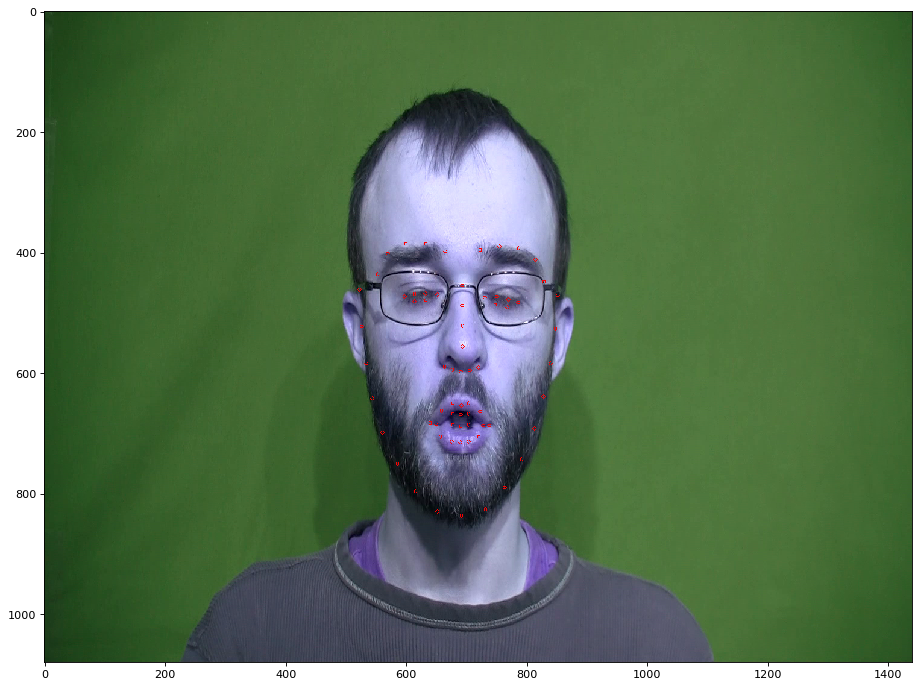

In [6]:
fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(dimage[20])

In [9]:
#MAIN FUNCTION: this function read a video file from a subject and then splits it into various spoken tokens based on the timing info 
# stored in subj_part_times.mat file. It also segments the face from the video and stores only the face. Lastly, the audio 
# is removed from the video and is stored in a separate file

import cv2
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
import scipy.misc as misc
from matplotlib import colors
import os
import numpy as np

#for face landmark points detection
import dlib
from imutils import face_utils
p = "scratch/avc/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(p)
detector_d = dlib.get_frontal_face_detector()


#for optical flow
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (75,75),
                  maxLevel = 6,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 100, 0.003))

detector = MTCNN()


vext='.avi'
newlabels=[]
filelist=[]
dimage=[]
use_optical_flow=False
for s in range(10):
    for p in range(3):
        part=str(p+1)
        
        subj=str(1201+s)
        if(not((subj=='1105' and p==0) or (subj=='1108') or (subj=='1103' and p==1))):
            #read the segmentation times
            mat=scio.loadmat('scratch/avc/lisa_data/token_times2/'+subj+'_part'+part+'_times.mat')
            times=mat['times']
            label=mat['str']
            if(subj=='1101' and p==0):
                times=np.delete(times,85,1) #85 is duplicate in 1101
                label=np.delete(label,85,1)
            [a,num]=np.shape(times)

            if(subj=='1206' or subj=='1207'):
                imfile = 'scratch/avc/lisa_data/'+subj+'_elicitation_part'+part+'.MTS';
            else:
                imfile = 'scratch/avc/lisa_data/'+subj+'_elicitation_part'+part+'.wmv';
            path='/home/saurabh/scratch/avc/'
            vid = cv2.VideoCapture(imfile)
            fps=30
            print(fps)
            i=1
            while(vid.isOpened()):
                retval, image = vid.read()
                #image=misc.imresize(image,0.5)
                frame_num=vid.get(cv2.CAP_PROP_POS_FRAMES)
                if(frame_num==1):
                    optflow=[]
                    os.system('mkdir -p scratch/avc/lisa_data_opt/'+subj)
                # detect face for the first frame only
                if(i<np.shape(times)[1]):
                    if(label[0,i]=='cooed' or label[0,i]=='kid' or label[0,i]=='cod' or label[0,i]=='keyed' or label[0,i]=='cud' or label[0,i]=='could'):
                        #hsv= colors.rgb_to_hsv(image)
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        #gray=np.uint8(hsv[:,:,2])
                        
                        stframe=round(times[0,i]*fps)-7
                        endframe=round(times[1,i]*fps)+7
                        if(frame_num==stframe):
                            # if this is the first frame in video create file   
                            faces = detector.detect_faces(image)
                            #only if faces are detected
                            if(len(faces)>0):
                                optflow=[]
                                x,y,w, h =faces[0]['box']
                                nx,ny=faces[0]['keypoints']['nose']
                                lmx,lmy=faces[0]['keypoints']['mouth_left']
                                rmx,rmy=faces[0]['keypoints']['mouth_right']
                                lex,ley=faces[0]['keypoints']['left_eye']
                                rex,rey=faces[0]['keypoints']['right_eye']
                                #optflow.append([lmx-nx,lmy-ny,rmx-nx,rmy-ny,lex-nx,ley-ny,rex-nx,rey-ny])
                                #width = rmx -lmx +2*offset
                                #height = 2*(lmy-ny) - offset
                                
                                #print(nx,ny, lmx, lmy, rmx, rmy)
                                #rects = detector_d(gray, 0)
                                rect = dlib.rectangle(left=x, top=y, right=x+w, bottom=y+h)
                                shape = predictor(gray, rect)
                                p0 = face_utils.shape_to_np(shape)          
                                #save/prepare variables for next iteration
                                if(use_optical_flow):
                                    p0 = np.round(p0.reshape(-1,1,2))
                                    old_gray = gray.copy()
                                    
                                optflow.append(p0)

                                ##debug below
                                #print(np.shape(optflow), np.shape(p0))
                                #for i in range(68):
                                #    x=p0[i,0,0]
                                #    y=p0[i,0,1]
                                #    pos=(int(x),int(y))
                                #    cv2.circle(image, pos, 7, color=(0, 255, 255))
                                #plt.imshow(image)
                                #break
                            else:
                                print("================================ ")
                                print("Error: Face not detected !!!!!!! ")
                                print("================================ ")
                         
                        if(frame_num>stframe):
                            # calculate optical flow
                            if(use_optical_flow):
                                p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray, np.float32(p0), None, **lk_params) 
                                # Now update the previous frame and previous points
                                old_gray = gray.copy()
                                p1 = np.round(p1.reshape(-1,1,2))
                            else:
                                rect = dlib.rectangle(left=x, top=y, right=x+w, bottom=y+h)
                                shape = predictor(gray, rect)
                                p1 = face_utils.shape_to_np(shape)  
                                
                            optflow.append(p1)
                            ##debug below
                            #for lmp in range(68):
                            #    x1=p1[lmp,0]
                            #    y1=p1[lmp,1]
                            #    pos=(int(x1),int(y1))
                            #    cv2.circle(image, pos, 3, color=(255, 0, 0))
                            ##dimage.append(image)
                            
                        if(frame_num==endframe):
                            newlabels.append(label[0,i])
                            print(label[0,i])
                            #separate audio from video
                            out_file='scratch/avc/lisa_data_opt/'+subj+'/'+subj+'_part'+part+'_'+str(label[0,i]).strip('[\']')+'_'+str(stframe)+'_'+str(endframe)+'_optflow'
                            print(out_file)
                            filelist.append(out_file)
                            np.save(out_file,optflow)
                            #os.system('ffmpeg -i '+ imfile +' -ss '+str(times[0,i])+ ' -to ' +str(times[1,i])+ ' -ac 1 -ar 16000 '+out_file+'_audio.wav')
                            #os.system('ffmpeg -i '+ imfile +' -ss '+str(times[0,i]-0.2)+ ' -to ' +str(times[1,i]+0.2)+ ' -acodec copy -vcodec copy '+ out_file+'_both.wmv')
                            
                            i=i+1
                            optflow=[]
                            #print('releasing video')
                            #vid.release()
                    else: #skip if the labels are not cud,keyed etc
                        i=i+1
                else: #if the i > shape
                    vid.release()
np.save('labels_1200.mat',newlabels)
np.save('filelist_1200.mat',filelist)


30
['cod']
scratch/avc/lisa_data_opt/1201/1201_part1_cod_3109.0_3151.0_optflow
['cod']
scratch/avc/lisa_data_opt/1201/1201_part1_cod_3415.0_3454.0_optflow
['kid']
scratch/avc/lisa_data_opt/1201/1201_part1_kid_4718.0_4759.0_optflow
['kid']
scratch/avc/lisa_data_opt/1201/1201_part1_kid_4925.0_4965.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1201/1201_part1_cooed_5170.0_5213.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1201/1201_part1_cooed_5383.0_5425.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1201/1201_part1_keyed_5600.0_5641.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1201/1201_part1_keyed_5812.0_5854.0_optflow
['could']
scratch/avc/lisa_data_opt/1201/1201_part1_could_6485.0_6525.0_optflow
['cud']
scratch/avc/lisa_data_opt/1201/1201_part1_cud_8030.0_8069.0_optflow
['could']
scratch/avc/lisa_data_opt/1201/1201_part1_could_8770.0_8809.0_optflow
['could']
scratch/avc/lisa_data_opt/1201/1201_part1_could_8995.0_9034.0_optflow
['kid']
scratch/avc/lisa_data_opt/1201/1201_part1_kid_977

['cod']
scratch/avc/lisa_data_opt/1201/1201_part2_cod_25883.0_25923.0_optflow
['cod']
scratch/avc/lisa_data_opt/1201/1201_part2_cod_26054.0_26093.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1201/1201_part2_cooed_26257.0_26297.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1201/1201_part2_cooed_26432.0_26475.0_optflow
30
['kid']
scratch/avc/lisa_data_opt/1201/1201_part3_kid_1685.0_1723.0_optflow
['kid']
scratch/avc/lisa_data_opt/1201/1201_part3_kid_1870.0_1907.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1201/1201_part3_cooed_2099.0_2141.0_optflow
['cod']
scratch/avc/lisa_data_opt/1201/1201_part3_cod_2963.0_3003.0_optflow
['cod']
scratch/avc/lisa_data_opt/1201/1201_part3_cod_3121.0_3160.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1201/1201_part3_keyed_3316.0_3355.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1201/1201_part3_keyed_3511.0_3550.0_optflow
['cud']
scratch/avc/lisa_data_opt/1201/1201_part3_cud_5177.0_5213.0_optflow
['cud']
scratch/avc/lisa_data_opt/1201/1201_part3_cud_536

['kid']
scratch/avc/lisa_data_opt/1202/1202_part1_kid_23494.0_23530.0_optflow
['kid']
scratch/avc/lisa_data_opt/1202/1202_part1_kid_23641.0_23677.0_optflow
['could']
scratch/avc/lisa_data_opt/1202/1202_part1_could_24184.0_24219.0_optflow
['cod']
scratch/avc/lisa_data_opt/1202/1202_part1_cod_24325.0_24363.0_optflow
['cod']
scratch/avc/lisa_data_opt/1202/1202_part1_cod_24469.0_24511.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1202/1202_part1_cooed_25091.0_25131.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1202/1202_part1_cooed_25273.0_25313.0_optflow
['cud']
scratch/avc/lisa_data_opt/1202/1202_part1_cud_26803.0_26839.0_optflow
30
['cod']
scratch/avc/lisa_data_opt/1202/1202_part2_cod_1312.0_1351.0_optflow
['cod']
scratch/avc/lisa_data_opt/1202/1202_part2_cod_1507.0_1549.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1202/1202_part2_cooed_1847.0_1885.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1202/1202_part2_cooed_2008.0_2052.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1202/1202_par

['cod']
scratch/avc/lisa_data_opt/1202/1202_part3_cod_17552.0_17590.0_optflow
['cod']
scratch/avc/lisa_data_opt/1202/1202_part3_cod_17701.0_17740.0_optflow
['cod']
scratch/avc/lisa_data_opt/1202/1202_part3_cod_20020.0_20057.0_optflow
['cod']
scratch/avc/lisa_data_opt/1202/1202_part3_cod_20191.0_20236.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1202/1202_part3_cooed_20653.0_20693.0_optflow
['cud']
scratch/avc/lisa_data_opt/1202/1202_part3_cud_20807.0_20843.0_optflow
['cud']
scratch/avc/lisa_data_opt/1202/1202_part3_cud_20935.0_20979.0_optflow
['could']
scratch/avc/lisa_data_opt/1202/1202_part3_could_21155.0_21191.0_optflow
['could']
scratch/avc/lisa_data_opt/1202/1202_part3_could_21311.0_21351.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1202/1202_part3_keyed_21494.0_21532.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1202/1202_part3_keyed_21625.0_21669.0_optflow
['kid']
scratch/avc/lisa_data_opt/1202/1202_part3_kid_23222.0_23259.0_optflow
['kid']
scratch/avc/lisa_data_opt/1202/1202_

['cooed']
scratch/avc/lisa_data_opt/1203/1203_part2_cooed_16637.0_16677.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1203/1203_part2_cooed_16769.0_16816.0_optflow
['could']
scratch/avc/lisa_data_opt/1203/1203_part2_could_17566.0_17599.0_optflow
['cud']
scratch/avc/lisa_data_opt/1203/1203_part2_cud_17987.0_18021.0_optflow
['cod']
scratch/avc/lisa_data_opt/1203/1203_part2_cod_18121.0_18157.0_optflow
['cod']
scratch/avc/lisa_data_opt/1203/1203_part2_cod_18251.0_18299.0_optflow
['kid']
scratch/avc/lisa_data_opt/1203/1203_part2_kid_18721.0_18759.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1203/1203_part2_keyed_19175.0_19216.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1203/1203_part2_keyed_19277.0_19327.0_optflow
['could']
scratch/avc/lisa_data_opt/1203/1203_part2_could_20891.0_20926.0_optflow
['could']
scratch/avc/lisa_data_opt/1203/1203_part2_could_21031.0_21077.0_optflow
['cud']
scratch/avc/lisa_data_opt/1203/1203_part2_cud_21187.0_21225.0_optflow
['cud']
scratch/avc/lisa_data_opt/12

['cooed']
scratch/avc/lisa_data_opt/1204/1204_part1_cooed_20108.0_20151.0_optflow
['kid']
scratch/avc/lisa_data_opt/1204/1204_part1_kid_20561.0_20601.0_optflow
['kid']
scratch/avc/lisa_data_opt/1204/1204_part1_kid_20839.0_20879.0_optflow
['cod']
scratch/avc/lisa_data_opt/1204/1204_part1_cod_21056.0_21095.0_optflow
['cod']
scratch/avc/lisa_data_opt/1204/1204_part1_cod_21181.0_21223.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1204/1204_part1_keyed_21811.0_21850.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1204/1204_part1_keyed_22001.0_22047.0_optflow
['could']
scratch/avc/lisa_data_opt/1204/1204_part1_could_22544.0_22583.0_optflow
['could']
scratch/avc/lisa_data_opt/1204/1204_part1_could_22658.0_22697.0_optflow
['cud']
scratch/avc/lisa_data_opt/1204/1204_part1_cud_22864.0_22905.0_optflow
['cud']
scratch/avc/lisa_data_opt/1204/1204_part1_cud_23038.0_23079.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1204/1204_part1_keyed_24689.0_24730.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1204

['keyed']
scratch/avc/lisa_data_opt/1204/1204_part3_keyed_13127.0_13169.0_optflow
['could']
scratch/avc/lisa_data_opt/1204/1204_part3_could_13328.0_13366.0_optflow
['kid']
scratch/avc/lisa_data_opt/1204/1204_part3_kid_14941.0_14981.0_optflow
['kid']
scratch/avc/lisa_data_opt/1204/1204_part3_kid_15148.0_15190.0_optflow
['cod']
scratch/avc/lisa_data_opt/1204/1204_part3_cod_15358.0_15398.0_optflow
['cod']
scratch/avc/lisa_data_opt/1204/1204_part3_cod_15617.0_15661.0_optflow
['cud']
scratch/avc/lisa_data_opt/1204/1204_part3_cud_18193.0_18232.0_optflow
['cud']
scratch/avc/lisa_data_opt/1204/1204_part3_cud_18343.0_18382.0_optflow
['kid']
scratch/avc/lisa_data_opt/1204/1204_part3_kid_18520.0_18559.0_optflow
['could']
scratch/avc/lisa_data_opt/1204/1204_part3_could_19205.0_19243.0_optflow
['could']
scratch/avc/lisa_data_opt/1204/1204_part3_could_19379.0_19419.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1204/1204_part3_cooed_19681.0_19719.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1204/120

['could']
scratch/avc/lisa_data_opt/1205/1205_part2_could_13622.0_13665.0_optflow
['could']
scratch/avc/lisa_data_opt/1205/1205_part2_could_13780.0_13825.0_optflow
['kid']
scratch/avc/lisa_data_opt/1205/1205_part2_kid_16127.0_16163.0_optflow
['kid']
scratch/avc/lisa_data_opt/1205/1205_part2_kid_16336.0_16379.0_optflow
['cod']
scratch/avc/lisa_data_opt/1205/1205_part2_cod_16990.0_17029.0_optflow
['cod']
scratch/avc/lisa_data_opt/1205/1205_part2_cod_17128.0_17179.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1205/1205_part2_keyed_18116.0_18159.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1205/1205_part2_keyed_18283.0_18335.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1205/1205_part2_cooed_18566.0_18604.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1205/1205_part2_cooed_18766.0_18821.0_optflow
['kid']
scratch/avc/lisa_data_opt/1205/1205_part2_kid_19472.0_19507.0_optflow
['kid']
scratch/avc/lisa_data_opt/1205/1205_part2_kid_19637.0_19689.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1205

['kid']
scratch/avc/lisa_data_opt/1206/1206_part1_kid_7157.0_7195.0_optflow
['cud']
scratch/avc/lisa_data_opt/1206/1206_part1_cud_7958.0_7995.0_optflow
['cud']
scratch/avc/lisa_data_opt/1206/1206_part1_cud_8140.0_8176.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1206/1206_part1_cooed_10258.0_10297.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1206/1206_part1_cooed_10427.0_10467.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1206/1206_part1_keyed_10618.0_10655.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1206/1206_part1_keyed_10763.0_10801.0_optflow
['cod']
scratch/avc/lisa_data_opt/1206/1206_part1_cod_10978.0_11017.0_optflow
['cod']
scratch/avc/lisa_data_opt/1206/1206_part1_cod_11182.0_11225.0_optflow
['cud']
scratch/avc/lisa_data_opt/1206/1206_part1_cud_11381.0_11421.0_optflow
['cud']
scratch/avc/lisa_data_opt/1206/1206_part1_cud_11573.0_11613.0_optflow
['kid']
scratch/avc/lisa_data_opt/1206/1206_part1_kid_12164.0_12201.0_optflow
['kid']
scratch/avc/lisa_data_opt/1206/1206_part1_kid_

['cud']
scratch/avc/lisa_data_opt/1206/1206_part3_cud_4825.0_4859.0_optflow
['cud']
scratch/avc/lisa_data_opt/1206/1206_part3_cud_4970.0_5007.0_optflow
['could']
scratch/avc/lisa_data_opt/1206/1206_part3_could_5150.0_5185.0_optflow
['could']
scratch/avc/lisa_data_opt/1206/1206_part3_could_5320.0_5355.0_optflow
['cod']
scratch/avc/lisa_data_opt/1206/1206_part3_cod_5807.0_5843.0_optflow
['cod']
scratch/avc/lisa_data_opt/1206/1206_part3_cod_5933.0_5974.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1206/1206_part3_cooed_6101.0_6139.0_optflow
['cooed']
scratch/avc/lisa_data_opt/1206/1206_part3_cooed_6259.0_6297.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1206/1206_part3_keyed_6476.0_6515.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1206/1206_part3_keyed_6616.0_6657.0_optflow
['could']
scratch/avc/lisa_data_opt/1206/1206_part3_could_7688.0_7726.0_optflow
['could']
scratch/avc/lisa_data_opt/1206/1206_part3_could_7810.0_7846.0_optflow
['kid']
scratch/avc/lisa_data_opt/1206/1206_part3_kid_84

['cud']
scratch/avc/lisa_data_opt/1207/1207_part2_cud_3677.0_3717.0_optflow
['cud']
scratch/avc/lisa_data_opt/1207/1207_part2_cud_3839.0_3885.0_optflow
['could']
scratch/avc/lisa_data_opt/1207/1207_part2_could_4349.0_4390.0_optflow
['could']
scratch/avc/lisa_data_opt/1207/1207_part2_could_4508.0_4552.0_optflow
['kid']
scratch/avc/lisa_data_opt/1207/1207_part2_kid_4721.0_4757.0_optflow
['could']
scratch/avc/lisa_data_opt/1207/1207_part2_could_5203.0_5242.0_optflow
['could']
scratch/avc/lisa_data_opt/1207/1207_part2_could_5362.0_5405.0_optflow
['cud']
scratch/avc/lisa_data_opt/1207/1207_part2_cud_6994.0_7035.0_optflow
['cud']
scratch/avc/lisa_data_opt/1207/1207_part2_cud_7154.0_7195.0_optflow
['cod']
scratch/avc/lisa_data_opt/1207/1207_part2_cod_7343.0_7384.0_optflow
['cod']
scratch/avc/lisa_data_opt/1207/1207_part2_cod_7502.0_7547.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1207/1207_part2_keyed_7712.0_7751.0_optflow
['keyed']
scratch/avc/lisa_data_opt/1207/1207_part2_keyed_7904.0_795

error: OpenCV(4.2.0) /tmp/ebuser/avx/OpenCV/4.2.0/gmkl-2018.3/opencv-4.2.0/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
